LTU MCS5993 by CJ Chung, F2025

### HW5 Assignment Disclaimer
*	Author Name: V Harsha Yellela
*	LTU ID: 000798754
*	Work Ownership: This work is my own. It is not copied from classmates (Yes/No): Yes
*	AI Assistance: Percentage of code generated with AI tools
(If greater than 0%, briefly describe how AI was used): 20% — AI was used to understand GRU/LSTM model design, ES(1+1) implementation, and hyperparameter tuning concepts for time series forecasting.
*	Understanding: I understand every part of this code (Yes/No):  Yes
*	Confidence: I am confident that I can modify, adapt, and extend this code on my own (Yes/No): Yes

## AirQualityUCI.csv
To predict Total Nitrogen Oxides (NOx)
```
Date;Time;CO(GT);PT08.S1(CO);NMHC(GT);C6H6(GT);PT08.S2(NMHC);NOx(GT);PT08.S3(NOx);NO2(GT);PT08.S4(NO2);PT08.S5(O3);T;RH;AH;;
10/03/2004;18.00.00;2,6;1360;150;11,9;1046;166;1056;113;1692;1268;13,6;48,9;0,7578;;
10/03/2004;19.00.00;2;1292;112;9,4;955;103;1174;92;1559;972;13,3;47,7;0,7255;;
10/03/2004;20.00.00;2,2;1402;88;9,0;939;131;1140;114;1555;1074;11,9;54,0;0,7502;;
10/03/2004;21.00.00;2,2;1376;80;9,2;948;172;1092;122;1584;1203;11,0;60,0;0,7867;;
10/03/2004;22.00.00;1,6;1272;51;6,5;836;131;1205;116;1490;1110;11,2;59,6;0,7888;;
10/03/2004;23.00.00;1,2;1197;38;4,7;750;89;1337;96;1393;949;11,2;59,2;0,7848;;
11/03/2004;00.00.00;1,2;1185;31;3,6;690;62;1462;77;1333;733;11,3;56,8;0,7603;;

```
https://archive.ics.uci.edu/dataset/360/air+quality

In [14]:
# import libraries
import pandas as pd
import statsmodels
from statsmodels.tsa.vector_ar.var_model import VAR
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# from google.colab import drive
# drive.mount('/content/gdrive')

# load the dataset
file_path = '/Desktop/MCS-5993-Evolutionary-Computation-and-Deep-Learning/Assignments/5/AirQualityUCI.csv'
data = pd.read_csv(file_path, delimiter=';')

In [21]:
# clean numeric columns
columns_to_clean = ['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH'] # origianl article did not include CO(GT)

# replace commas with dots and convert them to numeric
for col in columns_to_clean:
    data[col] = data[col].astype(str).str.replace(',', '.')
    data[col] = pd.to_numeric(data[col], errors='coerce')

# drop the unnamed columns and any rows with missing values
data_cleaned = data.drop(columns=['Unnamed: 15', 'Unnamed: 16'],errors='ignore').dropna()

# convert 'Date' and 'Time' to a single DateTime index <=== Not a colum!!!
data_cleaned['DateTime'] = pd.to_datetime(data_cleaned['Date'] + ' ' + data_cleaned['Time'], format='%d/%m/%Y %H.%M.%S')
data_cleaned = data_cleaned.set_index('DateTime')

# drop the 'Date' and 'Time' columns
data_cleaned = data_cleaned.drop(columns=['Date', 'Time'], errors='ignore')

data_cleaned = data_cleaned.replace(-200, np.nan)
data_cleaned = data_cleaned.dropna()

# ensure all columns are numeric
data_cleaned = data_cleaned.apply(pd.to_numeric, errors='coerce')

# drop rows with NaN
data_cleaned = data_cleaned.dropna()

# split the data (60% train, 20% validation, 20% test)
N = len(data_cleaned)
train_end = int(0.6 * N)
val_end = int(0.8 * N)

train_data = data_cleaned.iloc[:train_end]
val_data = data_cleaned.iloc[train_end:val_end]
test_data = data_cleaned.iloc[val_end:]

print(f"Train: {train_data.shape}, Val: {val_data.shape}, Test: {test_data.shape}")

# Normalize features based only on training data
scaler = MinMaxScaler()
scaler.fit(train_data)

train_scaled = pd.DataFrame(scaler.transform(train_data), columns=data_cleaned.columns, index=train_data.index)
val_scaled   = pd.DataFrame(scaler.transform(val_data),   columns=data_cleaned.columns, index=val_data.index)
test_scaled  = pd.DataFrame(scaler.transform(test_data),  columns=data_cleaned.columns, index=test_data.index)

print("Data cleaned, split, and normalized successfully!")

Train: (496, 13), Val: (165, 13), Test: (166, 13)
Data cleaned, split, and normalized successfully!


In [31]:
print(train_data.head(10))
print(train_data.shape)
# train_data.iloc[0]
print(train_data.tail(10))
train_scaled.info()
train_scaled.head()

                     CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  \
DateTime                                                                      
2004-03-10 18:00:00     2.6       1360.0     150.0      11.9         1046.0   
2004-03-10 19:00:00     2.0       1292.0     112.0       9.4          955.0   
2004-03-10 20:00:00     2.2       1402.0      88.0       9.0          939.0   
2004-03-10 21:00:00     2.2       1376.0      80.0       9.2          948.0   
2004-03-10 22:00:00     1.6       1272.0      51.0       6.5          836.0   
2004-03-10 23:00:00     1.2       1197.0      38.0       4.7          750.0   
2004-03-11 00:00:00     1.2       1185.0      31.0       3.6          690.0   
2004-03-11 01:00:00     1.0       1136.0      31.0       3.3          672.0   
2004-03-11 02:00:00     0.9       1094.0      24.0       2.3          609.0   
2004-03-11 05:00:00     0.7       1066.0       8.0       1.1          512.0   

                     NOx(GT)  PT08.S3(NOx)  NO2(GT)

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
DateTime,,,,,,,,,,,,,
2004-03-10 18:00:00,0.294872,0.449838,0.132776,0.292746,0.454125,0.330472,0.390007,0.537143,0.394107,0.464934,0.317391,0.497804,0.513580
2004-03-10 19:00:00,0.217949,0.394822,0.097493,0.227979,0.383963,0.195279,0.471895,0.417143,0.312462,0.319765,0.304348,0.480234,0.466917
2004-03-10 20:00:00,0.243590,0.483819,0.075209,0.217617,0.371627,0.255365,0.448300,0.542857,0.310006,0.369789,0.243478,0.572474,0.502600
2004-03-10 21:00:00,0.243590,0.462783,0.067781,0.222798,0.378566,0.343348,0.414990,0.588571,0.327808,0.433055,0.204348,0.660322,0.555331
2004-03-10 22:00:00,0.166667,0.378641,0.040854,0.152850,0.292213,0.255365,0.493407,0.554286,0.270104,0.387445,0.213043,0.654466,0.558365


In [41]:
# data preparation
n_lags = 3
target_col = 'NOx(GT)'

def create_lagged_features_lstm(data, target=target_col, n_lags=5):
    lagged_data = data.copy()
    for i in range(1, n_lags + 1):
        lagged_data[f'{target}_lag_{i}'] = lagged_data[target].shift(i)
    lagged_data = lagged_data.dropna() # drop any rows with missing values
    return lagged_data

# Apply to each dataset
train_data_lagged = create_lagged_features_lstm(train_scaled, target_col, n_lags)
val_data_lagged   = create_lagged_features_lstm(val_scaled,   target_col, n_lags)
test_data_lagged  = create_lagged_features_lstm(test_scaled,  target_col, n_lags)

# Verify lagged datasets
print(f"{train_data_lagged.iloc[0]}\n")
print(f"{val_data_lagged.iloc[0]}\n")
print(f"Train lagged shape: {train_data_lagged.shape} \n")
print(f"Val lagged shape:   {val_data_lagged.shape} \n")
print(f"Test lagged shape:  {test_data_lagged.shape} \n")
print(train_data_lagged.head())

CO(GT)           0.243590
PT08.S1(CO)      0.462783
NMHC(GT)         0.067781
C6H6(GT)         0.222798
PT08.S2(NMHC)    0.378566
NOx(GT)          0.343348
PT08.S3(NOx)     0.414990
NO2(GT)          0.588571
PT08.S4(NO2)     0.327808
PT08.S5(O3)      0.433055
T                0.204348
RH               0.660322
AH               0.555331
NOx(GT)_lag_1    0.255365
NOx(GT)_lag_2    0.195279
NOx(GT)_lag_3    0.330472
Name: 2004-03-10 21:00:00, dtype: float64

CO(GT)           0.294872
PT08.S1(CO)      0.300971
NMHC(GT)         0.272981
C6H6(GT)         0.352332
PT08.S2(NMHC)    0.513493
NOx(GT)          0.330472
PT08.S3(NOx)     0.223456
NO2(GT)          0.605714
PT08.S4(NO2)     0.343155
PT08.S5(O3)      0.366846
T                0.613043
RH               0.172767
AH               0.332274
NOx(GT)_lag_1    0.236052
NOx(GT)_lag_2    0.326180
NOx(GT)_lag_3    0.379828
Name: 2004-04-08 13:00:00, dtype: float64

Train lagged shape: (493, 16) 

Val lagged shape:   (162, 16) 

Test lagged shape:

In [47]:
# separate X and y
X_train_all_features = train_data_lagged.drop(columns=['NOx(GT)']).values  # Use all features
y_train = train_data_lagged['NOx(GT)'].values
print(X_train_all_features.shape)
print(y_train.shape)
print(y_train[0:5])
print(y_train[-5:])

X_val_all_features = val_data_lagged.drop(columns=['NOx(GT)']).values
y_val = val_data_lagged['NOx(GT)'].values

X_test_all_features = test_data_lagged.drop(columns=['NOx(GT)']).values
y_test = test_data_lagged['NOx(GT)'].values

# reshape data for LSTM (samples, timesteps, features)
# //  <--- floor division
X_train_lstm_all_features = X_train_all_features.reshape((X_train_all_features.shape[0], n_lags, X_train_all_features.shape[1] // n_lags))
X_val_lstm_all_features = X_val_all_features.reshape((X_val_all_features.shape[0], n_lags, X_val_all_features.shape[1] // n_lags))
X_test_lstm_all_features = X_test_all_features.reshape((X_test_all_features.shape[0], n_lags, X_test_all_features.shape[1] // n_lags))

print(f"\n \nTrain: {X_train_lstm_all_features.shape}")
print(f"Val:   {X_val_lstm_all_features.shape}")
print(f"Test:  {X_test_lstm_all_features.shape} \n \n")
print(X_train_lstm_all_features[0:5])
print()
print(X_train_lstm_all_features[-5:])


(493, 15)
(493,)
[0.34334764 0.25536481 0.16523605 0.10729614 0.10729614]
[0.1223176  0.13304721 0.31974249 0.63519313 0.61802575]

 
Train: (493, 3, 5)
Val:   (162, 3, 5)
Test:  (163, 3, 5) 
 

[[[0.24358974 0.46278317 0.06778087 0.22279793 0.37856592]
  [0.41498959 0.58857143 0.32780847 0.43305542 0.20434783]
  [0.66032211 0.55533083 0.25536481 0.19527897 0.3304721 ]]

 [[0.16666667 0.37864078 0.04085422 0.15284974 0.2922128 ]
  [0.49340736 0.55428571 0.27010436 0.38744483 0.21304348]
  [0.65446559 0.55836463 0.34334764 0.25536481 0.19527897]]

 [[0.11538462 0.31796117 0.02878366 0.10621762 0.22590594]
  [0.58501041 0.44       0.21055862 0.30848455 0.21304348]
  [0.64860908 0.55258596 0.25536481 0.34334764 0.25536481]]

 [[0.11538462 0.30825243 0.02228412 0.07772021 0.17964534]
  [0.67175573 0.33142857 0.17372621 0.20255027 0.2173913 ]
  [0.61346999 0.51719156 0.16523605 0.25536481 0.34334764]]

 [[0.08974359 0.26860841 0.02228412 0.06994819 0.16576715]
  [0.66551006 0.32571429 0.173

Epoch 1/100
16/16 [==============================] - 13s 19ms/step - loss: 0.0767 - val_loss: 0.0186
Epoch 2/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0123 - val_loss: 0.0126
Epoch 3/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0114 - val_loss: 0.0085
Epoch 4/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0086 - val_loss: 0.0067
Epoch 5/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0075 - val_loss: 0.0054
Epoch 6/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0063 - val_loss: 0.0046
Epoch 7/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0056 - val_loss: 0.0041
Epoch 8/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0050 - val_loss: 0.0038
Epoch 9/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0046 - val_loss: 0.0035
Epoch 10/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0042 - val_loss: 0.0034
Epoch 1

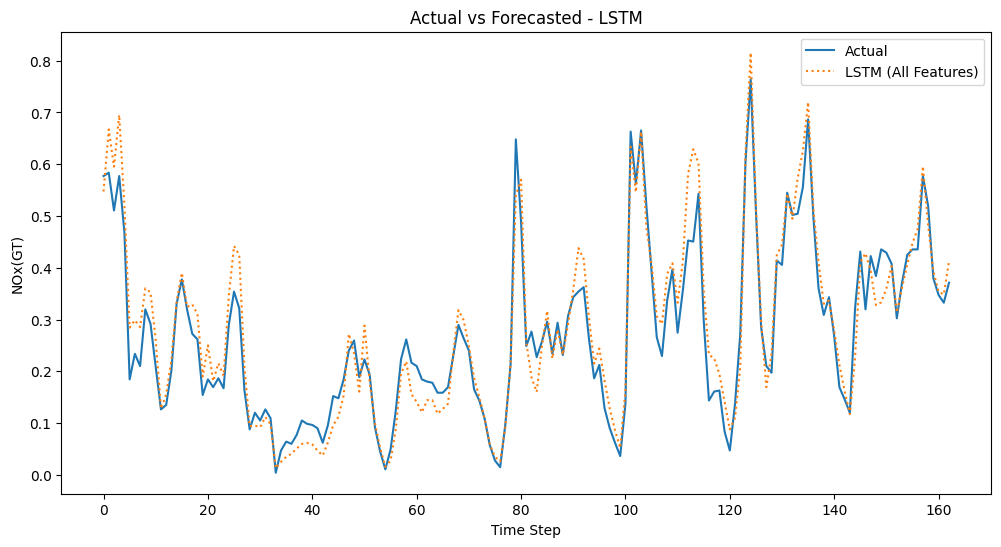

In [50]:
# import libraries
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# build the model
model_all_features = Sequential()
# model_all_features.add(LSTM(50, activation='relu', input_shape=(n_lags, X_train_lstm_all_features.shape[2]))) # 3, 5
model_all_features.add(LSTM(50, activation='tanh', recurrent_activation='sigmoid', input_shape=(n_lags, X_train_lstm_all_features.shape[2]))) # making it bit complex so it will use cudnn kernels
model_all_features.add(Dense(1))
model_all_features.compile(optimizer='adam', loss='mse')

# add early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# train
history_all_features = model_all_features.fit(X_train_lstm_all_features, y_train, epochs=100, batch_size=32, validation_data=(X_val_lstm_all_features, y_val), callbacks=[early_stopping], verbose=1)

# forecast
y_pred_all_features = model_all_features.predict(X_test_lstm_all_features)

# evaluate
rmse_all_features = np.sqrt(mean_squared_error(y_test, y_pred_all_features))
print(f'Root Mean Squared Error (RMSE): {rmse_all_features}')

loss = model_all_features.evaluate(X_test_lstm_all_features, y_test, verbose=0)
print(f'RMSE calculated from m.evaluate: {np.sqrt(loss)}')

# visualize
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred_all_features, label='LSTM (All Features)', linestyle=':')
plt.title('Actual vs Forecasted - LSTM')
plt.xlabel('Time Step')
plt.ylabel('NOx(GT)')
plt.legend()
plt.show()

0.0 1.0
Train lagged: (493, 16)
Val lagged:   (162, 16)
Test lagged:  (163, 16)
Train/Val/Test shapes:
(493, 15) (162, 15) (163, 15)
GRU input shapes:
(493, 3, 5) (162, 3, 5) (163, 3, 5)
Epoch 1/150
16/16 [==============================] - 1s 17ms/step - loss: 0.0505 - val_loss: 0.0224
Epoch 2/150
16/16 [==============================] - 0s 5ms/step - loss: 0.0167 - val_loss: 0.0104
Epoch 3/150
16/16 [==============================] - 0s 4ms/step - loss: 0.0093 - val_loss: 0.0055
Epoch 4/150
16/16 [==============================] - 0s 5ms/step - loss: 0.0057 - val_loss: 0.0037
Epoch 5/150
16/16 [==============================] - 0s 5ms/step - loss: 0.0041 - val_loss: 0.0030
Epoch 6/150
16/16 [==============================] - 0s 5ms/step - loss: 0.0036 - val_loss: 0.0029
Epoch 7/150
16/16 [==============================] - 0s 5ms/step - loss: 0.0033 - val_loss: 0.0029
Epoch 8/150
16/16 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 9/150
16/16 [=

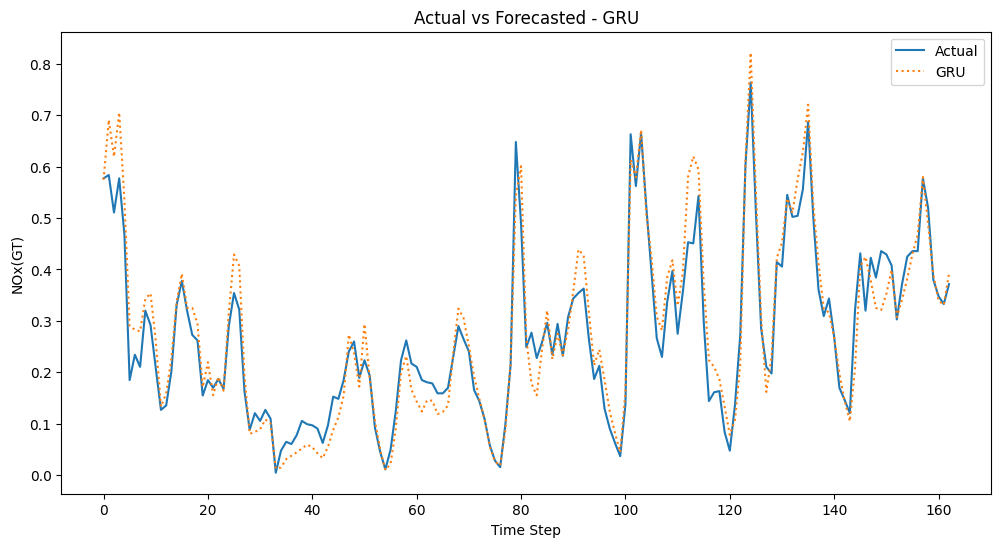

In [57]:
# import libraries
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping

# data prep
def create_lagged_features_gru(data, n_lags):
    lagged_data = data.copy()
    for i in range(1, n_lags + 1):
        lagged_data[f'NOx_lag_{i}'] = lagged_data['NOx(GT)'].shift(i)
    lagged_data = lagged_data.dropna()
    return lagged_data

n_lags = 3

print(train_scaled['NOx(GT)'].min(), train_scaled['NOx(GT)'].max())

# apply lagged feature generation to TRAIN / VAL / TEST
train_data_lagged = create_lagged_features_gru(train_scaled, n_lags)
val_data_lagged = create_lagged_features_gru(val_scaled, n_lags)
test_data_lagged = create_lagged_features_gru(test_scaled, n_lags)

print(f"Train lagged: {train_data_lagged.shape}")
print(f"Val lagged:   {val_data_lagged.shape}")
print(f"Test lagged:  {test_data_lagged.shape}")

# separate out X and y
X_train_all_features = train_data_lagged.drop(columns=['NOx(GT)']).values
y_train = train_data_lagged['NOx(GT)'].values

X_val_all_features = val_data_lagged.drop(columns=['NOx(GT)']).values
y_val = val_data_lagged['NOx(GT)'].values

X_test_all_features = test_data_lagged.drop(columns=['NOx(GT)']).values
y_test = test_data_lagged['NOx(GT)'].values

print("Train/Val/Test shapes:")
print(X_train_all_features.shape, X_val_all_features.shape, X_test_all_features.shape)

# reshape data for GRU (samples, timesteps, features)
X_train_gru_all_features = X_train_all_features.reshape((X_train_all_features.shape[0], n_lags, X_train_all_features.shape[1] // n_lags))
X_val_gru_all_features = X_val_all_features.reshape((X_val_all_features.shape[0], n_lags, X_val_all_features.shape[1] // n_lags))
X_test_gru_all_features = X_test_all_features.reshape((X_test_all_features.shape[0], n_lags, X_test_all_features.shape[1] // n_lags))

print("GRU input shapes:")
print(X_train_gru_all_features.shape, X_val_gru_all_features.shape, X_test_gru_all_features.shape)

# build GRU
model_gru_all_features = Sequential()
# model_gru_all_features.add(GRU(60, activation='relu', input_shape=(n_lags, X_train_gru_all_features.shape[2])))
model_gru_all_features.add(GRU(60, activation='tanh', recurrent_activation='sigmoid', input_shape=(n_lags, X_train_gru_all_features.shape[2]))) # making it bit complex so it will use cudnn kernels
model_gru_all_features.add(Dense(1))  # Output layer predicting one value (NOx(GT))
model_gru_all_features.compile(optimizer='adam', loss='mse')

# add early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# train
history_gru_all_features = model_gru_all_features.fit(X_train_gru_all_features, y_train, epochs=150, batch_size=32, validation_data=(X_val_gru_all_features, y_val), callbacks=[early_stopping], verbose=1)

# forecast
y_pred_gru_all_features = model_gru_all_features.predict(X_test_gru_all_features)

# evaluate
rmse_gru_all_features = np.sqrt(mean_squared_error(y_test, y_pred_gru_all_features))
print(f'Root Mean Squared Error (RMSE) for GRU (All Features): {rmse_gru_all_features}')

loss = model_gru_all_features.evaluate(X_test_gru_all_features, y_test, verbose=0)
print(f'RMSE calculated from m.evaluate: {np.sqrt(loss)}')

# visualize
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred_gru_all_features, label='GRU', linestyle=':')
plt.title('Actual vs Forecasted - GRU')
plt.xlabel('Time Step')
plt.ylabel('NOx(GT)')
plt.legend()
plt.show()

In [67]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping

def objective_ES(params):

    # --- Decode normalized parameters ---
    units = int(10 + params[0]*50)             # 10–60
    batch_size = int(16 + params[1]*48)        # 16–64
    epochs = int(20 + params[2]*80)           # 20-100
    n_lags = int(2 + params[3]*6)              # 2–8
    num_layers = int(1 + params[4]*1)          # 1–2 layers
    dropout = params[5]*0.5                    # 0–0.5
    patience = int(5 + params[6]*10)           # 5–15 patience

    # --- Prepare lagged datasets ---
    train_data_lagged = create_lagged_features_gru(train_scaled, n_lags)
    val_data_lagged   = create_lagged_features_gru(val_scaled,   n_lags)

    X_train = train_data_lagged.drop(columns=['NOx(GT)']).values
    y_train = train_data_lagged['NOx(GT)'].values
    X_val   = val_data_lagged.drop(columns=['NOx(GT)']).values
    y_val   = val_data_lagged['NOx(GT)'].values

    # --- Reshape ---
    features_per_step = X_train.shape[1] // n_lags
    X_train = X_train[:, :features_per_step * n_lags]
    X_val   = X_val[:, :features_per_step * n_lags]
    X_train = X_train.reshape(X_train.shape[0], n_lags, features_per_step)
    X_val   = X_val.reshape(X_val.shape[0], n_lags, features_per_step)

    # --- Build GRU model ---
    model = Sequential()
    for i in range(num_layers):
        return_seq = (i < num_layers - 1)
        if i == 0:
            model.add(GRU(units, activation='tanh', recurrent_activation='sigmoid',
                          dropout=dropout, return_sequences=return_seq,
                          input_shape=(n_lags, X_train.shape[2])))
        else:
            model.add(GRU(units, activation='tanh', recurrent_activation='sigmoid',
                          dropout=dropout, return_sequences=return_seq))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')

    # --- Early stopping with variable patience ---
    early_stop = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
              validation_data=(X_val, y_val), callbacks=[early_stop], verbose=0)

    val_loss = model.evaluate(X_val, y_val, verbose=0)
    return val_loss, model, (units, batch_size, epochs, n_lags, num_layers, dropout, patience)


# --- ES(1+1) Algorithm ---
def es_1p1(objective_func, xp_init, step_i=0.3, WindowSize=10, MaxGen=25):
    xp = xp_init.copy()
    fp, model_best, decoded_best = objective_func(xp)
    success = 0
    step = step_i
    best_gen = 0

    for gen in range(1, MaxGen+1):
        xo = np.clip(xp + np.random.normal(0, step, len(xp)), 0, 1)
        fo, model_cand, decoded_cand = objective_func(xo)

        if fo < fp:
            xp, fp, model_best, decoded_best = xo, fo, model_cand, decoded_cand
            success += 1
            best_gen = gen

        if gen % WindowSize == 0:
            if success > WindowSize/5:
                step /= 0.82
            elif success < WindowSize/5:
                step *= 0.82
            success = 0

    return xp, fp, model_best, decoded_best, best_gen


# --- Run ES(1+1) Optimization ---
maxTrials = 5
MaxGen = 10
WindowSize = 10
stepSize = 0.3
successCnt = 0

for trial in range(1, maxTrials+1):
    best_params, best_val_loss, best_model, decoded, best_gen = es_1p1(
        objective_ES, np.random.rand(7), stepSize, WindowSize, MaxGen
    )
    val_rmse = np.sqrt(best_val_loss)
    units, batch_size, epochs, n_lags, num_layers, dropout, patience = decoded

    if best_val_loss < 0.002:  # success criterion
        print(f"Trial = {trial}, Acceptable solution found at generation {best_gen}")
        print(f"\tUnits: {units}")
        print(f"\tBatch Size: {batch_size}")
        print(f"\tEpochs: {epochs}")
        print(f"\tLags: {n_lags}")
        print(f"\tLayers: {num_layers}")
        print(f"\tDropout: {dropout:.2f}")
        print(f"\tPatience: {patience}")
        print(f"\tValidation RMSE = {val_rmse:.5f}")

        # --- Evaluate on test set ---
        test_data_lagged = create_lagged_features_gru(test_scaled, n_lags)
        X_test = test_data_lagged.drop(columns=['NOx(GT)']).values
        y_test = test_data_lagged['NOx(GT)'].values
        features_per_step = X_test.shape[1] // n_lags
        X_test = X_test[:, :features_per_step * n_lags]
        X_test = X_test.reshape(X_test.shape[0], n_lags, features_per_step)
        test_loss = best_model.evaluate(X_test, y_test, verbose=0)
        print(f"\tTest RMSE = {np.sqrt(test_loss):.5f}")
        print("------------------------------------------------------")
        successCnt += 1
    else:
        print(f"Trial = {trial},\t{best_val_loss:.5f}\tTerminated, since no improvement.")
        print("------------------------------------------------------")

print(f"System Success Rate: {successCnt/maxTrials*100:.1f}%")


Trial = 1, Acceptable solution found at generation 2
	Units: 10
	Batch Size: 45
	Epochs: 96
	Lags: 2
	Layers: 1
	Dropout: 0.04
	Patience: 5
	Validation RMSE = 0.04358
	Test RMSE = 0.05149
------------------------------------------------------
Trial = 2, Acceptable solution found at generation 10
	Units: 59
	Batch Size: 32
	Epochs: 56
	Lags: 3
	Layers: 1
	Dropout: 0.00
	Patience: 15
	Validation RMSE = 0.04388
	Test RMSE = 0.04254
------------------------------------------------------
Trial = 3,	0.00207	Terminated, since no improvement.
------------------------------------------------------
Trial = 4, Acceptable solution found at generation 6
	Units: 57
	Batch Size: 16
	Epochs: 100
	Lags: 4
	Layers: 1
	Dropout: 0.00
	Patience: 10
	Validation RMSE = 0.04369
	Test RMSE = 0.04612
------------------------------------------------------
Trial = 5,	0.00210	Terminated, since no improvement.
------------------------------------------------------
System Success Rate: 60.0%


In [68]:
# dataframe shift() test
import pandas as pd

df = pd.DataFrame({'A': [1, 2, 3, 4], 'B': [5, 6, 7, 8], 'C': [9, 0, 1, 2]})
print(df)
# Shift the data down by 1 row
df_shifted_down = df.shift(1)
print(df_shifted_down)

   A  B  C
0  1  5  9
1  2  6  0
2  3  7  1
3  4  8  2
     A    B    C
0  NaN  NaN  NaN
1  1.0  5.0  9.0
2  2.0  6.0  0.0
3  3.0  7.0  1.0


In [69]:
n = 2
df = pd.DataFrame({'A': [1, 2, 3, 4], 'B': [5, 6, 7, 8], 'C': [9, 0, 1, 2]})
for i in range(1, n + 1):
    df[f'lag_{i}'] = df['B'].shift(i)
df_shifted_down = df.shift(1)
print(df_shifted_down)

     A    B    C  lag_1  lag_2
0  NaN  NaN  NaN    NaN    NaN
1  1.0  5.0  9.0    NaN    NaN
2  2.0  6.0  0.0    5.0    NaN
3  3.0  7.0  1.0    6.0    5.0
